In [1]:
import numpy as np
from scipy.interpolate import interp1d
import sys
import matplotlib.pyplot as plt

from ipywidgets import widgets
from ipywidgets.widgets import interact

from matplotlib.patches import Rectangle

In [2]:
%gui qt

In [3]:
%matplotlib inline

In [4]:
from Algo2.generate_smooth_curve import generate_smooth_curve
from Algo2.diff_algorithm import calculate_diff_between_input_and_curve, calculate_jumps
from utilities.export_files import excel_format

In [5]:
inputFile = 'testin.txt'
smoothedOutput = "output.xls"
thresholdOutput = 0.75
window = 0.0375
threshold = 0.0025 #initial threshold guess

### load data

In [6]:
#isolate x and y data
data = np.loadtxt(inputFile)
x = data[:,0]
y = data[:,1]

In [7]:
x2y2 = generate_smooth_curve(x, y, window)
x2 = x2y2['x2']
y2 = x2y2['y2']

excel_format(x2, y2, smoothedOutput)

In [8]:
# generate cubic spline interpolation and plot
poly = interp1d(x2, y2, kind='cubic')
xi = np.linspace(x2[0], x2[x2.size - 1], num=(x2[x2.size - 1] - x2[0])/.001, endpoint=True)

# calculate diff between input and curve
ydiff = calculate_diff_between_input_and_curve(x, y, x2, poly)

### plot with threshold values marked

In [31]:
def all_plots(threshold):
    
    fig, ax = plt.subplots(figsize=(15,15))
    ori, = ax.plot(x, y, 'o-', color='g') # plot original points
    cs, = ax.plot(xi, poly(xi), color='c') # plot cubic spline
    ax.plot(x2, y2, 'o', color = 'c') # plot smoothed curve
    
    plt.xlabel("Wavelength (Angs)", fontsize=15)
    plt.ylabel("(Raw - OB) / OB", fontsize=15)
    plt.title("Neutron Imaging Graph", fontsize=15)
    
    ws = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    plt.legend([ws, ori, cs], ("window size: " + str(window * 2), "original data", "cubic spline"), loc='best')
    maxjumps = calculate_jumps(threshold, ydiff, x2, x)
    for i in range(0, maxjumps.size): # mark x-values of points exceeding threshold
        ax.axvline(x=maxjumps[i], color='r')
    
    fig.show()
    
    return threshold

Maximal points exceeding threshold 0.00092: [ 1.40120586  1.44148871  1.64290295  1.82165809  2.07555019  2.20395177
  2.47837868  2.8887602   3.07003302  3.26267473  3.41373542  3.58493753
  3.7158617   3.7813115   3.83166506  4.00539468  4.04062742  4.36541773]


0.00092

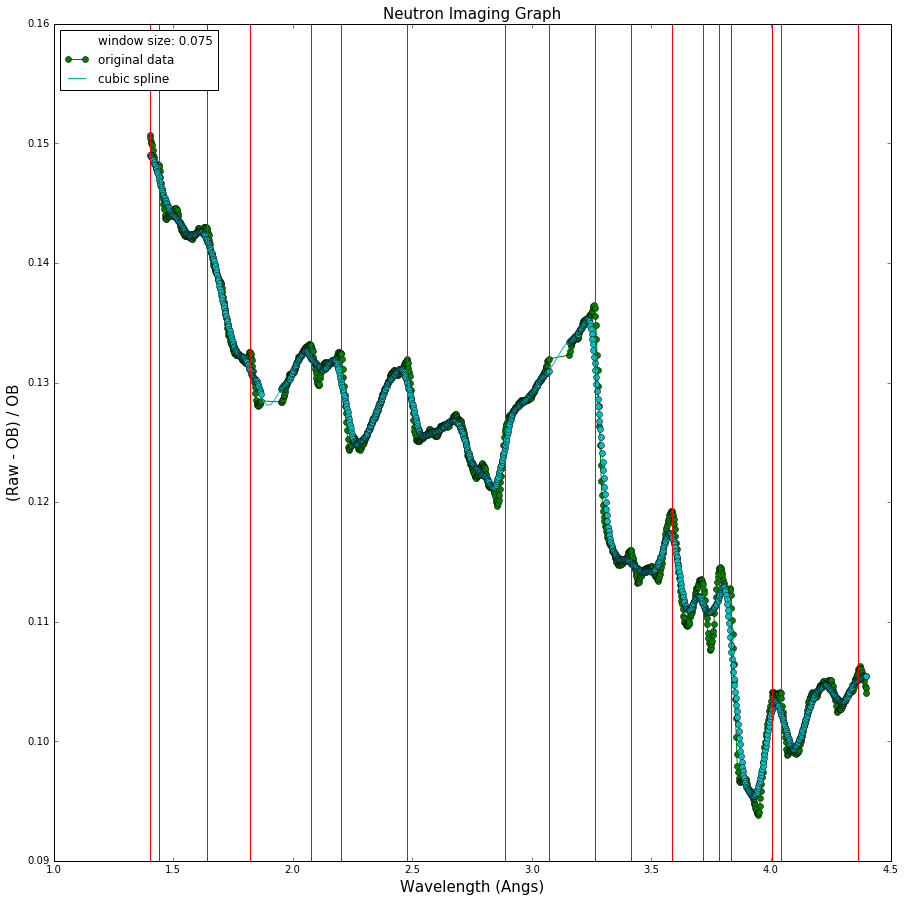

In [32]:
step = interact(all_plots, threshold = widgets.FloatSlider( min = 0.000,
                                                          max = 0.005,
                                                          step = 0.00001,
                                                          value = 0.0025,
                                                          description = 'Threshold'))